# Taichi Hackathon 2022
Team: Sweet Point

## FACET
>  a **FA**st diamond **C**ut **E**stimator powered by **T**aichi

### Background
I really bought a diamond
Before that, I did some research in order to buy the most sparkling one

### About Diamond Cut
![jupyter](https://upload.wikimedia.org/wikipedia/commons/3/3a/Diamond_facets.svg)

### Parametric model of a round brilliant cut diamond


In [1]:
import numpy as np
import taichi as ti
import taichi.math as tm
from math import radians, sin, cos, tan, pi
ti.init(arch=ti.gpu)
plane_array = np.empty((57, 4), dtype=np.float32)
plane_field = ti.Vector.field(n=4,
                              dtype=ti.f32,
                              shape=57,
                              layout=ti.Layout.AOS)

[Taichi] version 1.3.0, llvm 15.0.1, commit 0f25b95e, win, python 3.9.15
[Taichi] Starting on arch=cuda


In [2]:
ANGLES = [42.1, 41, 42.3, 35, 19.8]
def cut_facet(symmetry, index, index_shift, radius, height, angle, i):
    gear_index = 64
    for _ in range(symmetry):
        theta = radians(index * 360 / gear_index)
        phi = angle
        p0 = [
            cos(radians((index + index_shift) * 360 / 64)) * radius,
            sin(radians((index + index_shift) * 360 / 64)) * radius, height
        ]
        n = [
            tan(phi) * tan(phi) * cos(theta),
            tan(phi) * tan(phi) * sin(theta),
            tan(phi)
        ]
        n /= np.linalg.norm(n)
        d = -np.dot(n, p0)
        plane_array[i] = [n[0], n[1], n[2], d]
        index = index + gear_index // symmetry
        i += 1
    return i
def init():
    i = 0
    p_phi0 = radians(-ANGLES[0])
    p_phi1 = radians(-ANGLES[1])
    c_phi0 = radians(ANGLES[2])
    c_phi1 = radians(ANGLES[3])
    c_phi2 = radians(ANGLES[4])
    #hacked several meetpoints of facets
    c_r1 = sin(
        pi / 8) * (tan(c_phi0) * sin(pi / 16) - tan(c_phi1) * sin(pi / 8)) / (
            tan(c_phi0) * cos(pi / 16) - tan(c_phi1) * cos(pi / 8)) + cos(
                pi / 8)
    c_z1 = tan(c_phi0) * sin(pi / 16) * sin(pi / 8) - tan(c_phi0) * cos(
        pi / 16) * sin(pi / 8) * (tan(c_phi0) * sin(pi / 16) - tan(c_phi1) *
                                  sin(pi / 8)) / (tan(c_phi0) * cos(pi / 16) -
                                                  tan(c_phi1) * cos(pi / 8))
    c_r2 = (c_r1 * tan(c_phi2) + c_z1 -
            tan(c_phi1)) / (cos(pi / 8) * tan(c_phi2) - tan(c_phi1))
    c_z2 = (1 - c_r2) * tan(c_phi1)
    p_r1 = sin(
        pi / 8) * (tan(p_phi0) * sin(pi / 16) - tan(p_phi1) * sin(pi / 8)) / (
            tan(p_phi0) * cos(pi / 16) - tan(p_phi1) * cos(pi / 8)) + cos(
                pi / 8)
    i = cut_facet(16, 2, -2, 1.0, 0.0, p_phi0, i)  #lower half facet
    i = cut_facet(8, 4, 0, 1.0, 0.0, p_phi1, i)  #pavillion main facet
    i = cut_facet(16, 2, -2, 1.0, 0.0, c_phi0, i)  #upper half facet
    i = cut_facet(8, 4, 0, 1.0, 0.0, c_phi1, i)  #bezel facet
    i = cut_facet(8, 0, 0, c_r1, c_z1, c_phi2, i)  #star facet
    plane_array[i] = [0, 0, 1, -c_z2]  #table
    plane_field.from_numpy(plane_array)
init()

### A tiny render 
> only concerns specular reflection and refraction

#### ray–convex colyhedron intersection


In [3]:
@ti.func
def intersect(ray):
    t_near, t_far = -tm.inf, tm.inf
    t = tm.inf
    index_near,index_far = -1, -1
    index = -1
    for i in range(57):
        p = plane_field[i]
        n = p.xyz
        d = p.w
        
        v_n= tm.dot(n, ray.origin) + d
        v_d = tm.dot(n,ray.direction)
        t = -v_n/v_d
        if v_d > 0:
            if t < t_far:
                t_far = t 
                index_far = i
        elif v_d < 0:
            if t > t_near:
                t_near = t
                index_near = i

    if t_near >= t_far:
        t = tm.inf
    else:
        if 0.0001 > t_far:
            t = tm.inf
        elif 0.0001 < t_near :
            t = t_near
            index = index_near
        else:
            t = t_far
            index = index_far
    return t, index

#### light weighted path tracing

In [4]:
@ti.func
def trace(ray):
    color = tm.vec3(0.0)
    reflectance = 1.0
    depth = 0
    while depth<50:
        t, index  = intersect(ray)
        if t==tm.inf:
            if ray.direction.z > 0:
                color = tm.vec3(1.0)*reflectance
            break

        ray.origin +=  ray.direction * t
        n = plane_field[index].xyz
        nl = n if n.dot(ray.direction) < 0 else -n

        into = n.dot(nl)>0
        n_i,n_t = 1, 2.42
        eta = n_i/n_t if into else n_t/n_i

        cos_theta_i = ray.direction.dot(nl)
        sin_theta_i = tm.sqrt(1 - cos_theta_i*cos_theta_i)
        sin_theta_t = sin_theta_i * eta

        if sin_theta_t >= 1:
            ray.direction = tm.reflect(ray.direction, nl)
        else:
            tdir = tm.refract(ray.direction,nl,eta)
            a = n_t-n_i
            b = n_t+n_i
            R0 = a*a/(b*b)
            c = 1-(-cos_theta_i if into else tdir.dot(n))
            R_eff = R0 + (1-R0)*c*c*c*c*c
            if ti.random() < R_eff:
                reflectance *= R_eff
                ray.direction = tm.reflect(ray.direction, nl)
            else:
                reflectance *=  (1 - R_eff)
                ray.direction = tm.refract(ray.direction, nl, eta)
        depth+=1
    return color

In [5]:
Ray = ti.types.struct(origin=tm.vec3, direction=tm.vec3)
@ti.func
def get_ray(u,
            v,
            look_from,
            look_at=tm.vec3(0, 0, 0),
            up=tm.vec3(0, 1, 0),
            fov=25):
    d = (look_at - look_from).normalized()
    film_u = tm.cross(d, up).normalized()  #right
    film_v = tm.cross(film_u, d).normalized()  #up
    d_u = film_u * 2 * tm.tan(tm.radians(fov) / 2)
    d_v = film_v * 2 * tm.tan(tm.radians(fov) / 2)
    return Ray(look_from, (d + (u - 0.5) * d_u + (v - 0.5) * d_v).normalized())

C:\Users\pengb\AppData\Local\Temp\ipykernel_15064\6993718.py:15: DeprecationWarning: Using conditional expression for element-wise select operation on Taichi vectors/matrices is deprecated. Please use "ti.select" instead.
  nl = n if n.dot(ray.direction) < 0 else -n


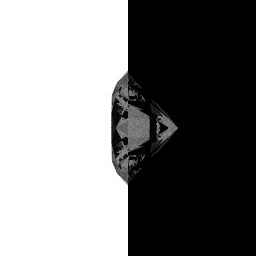

In [6]:
film = ti.Vector.field(n=3,dtype=ti.f32,shape=(256, 256))

spp = 64
@ti.kernel
def render(theta:ti.f32):
    look_from = tm.vec3(tm.cos(theta),tm.sin(theta),0)*10    
    for i,j in film:
        color = tm.vec3(0.0)
        for _ in range(spp):
            u = (i+ti.random())/256
            v = (j+ti.random())/256
            ray = get_ray(u,v,look_from)
            color += trace(ray)
        film[i,j] = color/spp

render(0)
ti.tools.imshow(film)

#### Spectral Rendering

In [7]:
Ray = ti.types.struct(origin=tm.vec3, direction=tm.vec3, wavelength = ti.f32)

In [8]:
@ti.func
def xFit_1931( wave ):
    t1 = (wave-442.0)*(0.0624 if wave < 442.0 else 0.0374)
    t2 = (wave-599.8)*(0.0264 if wave<599.8 else 0.0323)
    t3 = (wave-501.1)*(0.0490 if wave<501.1 else 0.0382)
    return 0.362*tm.exp(-0.5*t1*t1) + 1.056*tm.exp(-0.5*t2*t2)- 0.065*tm.exp(-0.5*t3*t3)
@ti.func
def yFit_1931( wave ):
    t1 = (wave-568.8)*(0.0213 if wave<568.8 else 0.0247)
    t2 = (wave-530.9)*(0.0613 if wave<530.9 else 0.0322)
    return 0.821*tm.exp(-0.5*t1*t1) + 0.286*tm.exp(-0.5*t2*t2)
@ti.func
def zFit_1931(  wave ):
    t1 = (wave-437.0)*(0.0845 if wave<437.0 else 0.0278)
    t2 = (wave-459.0)*(0.0385 if wave<459.0 else 0.0725)
    return 1.217 *tm.exp(-0.5*t1*t1) + 0.681*tm.exp(-0.5*t2*t2)

In [9]:
@ti.func
def trace(ray):
    color_xyz = tm.vec3(0.0)
    reflectance = 1.0
    ray_xyz =tm.vec3(xFit_1931(ray.wavelength),yFit_1931(ray.wavelength),zFit_1931(ray.wavelength))
    depth =0

    while depth<50:
        t, index  = intersect(ray)

        if t==tm.inf:
            if ray.direction.z > 0:
                color_xyz = ray_xyz*reflectance
            break
        n = plane_field[index].xyz

        ray.origin += ray.direction * t
        nl = n if n.dot(ray.direction) < 0 else -n

        into = n.dot(nl)>0
        n_i = 1.0
        #n_t = 2.3818 + 0.0121*1e6/(ray.wavelength*ray.wavelength)
        n_t = 2.42 + 0.044*1e6/(ray.wavelength*ray.wavelength)
        
        eta = n_i/n_t if into else n_t/n_i
        
        cos_theta_i = ray.direction.dot(nl)
        sin_theta_i = tm.sqrt(1 - cos_theta_i*cos_theta_i)
        sin_theta_t = sin_theta_i * eta

        if sin_theta_t >= 1:
            ray.direction = tm.reflect(ray.direction, nl)
        else:
            tdir = tm.refract(ray.direction,nl,eta)
            a = n_t-n_i
            b = n_t+n_i
            R0 = a*a/(b*b)
            c = 1-(-cos_theta_i if into else tdir.dot(n))
            R_eff = R0 + (1-R0)*c*c*c*c*c
            if ti.random() < R_eff:
                reflectance *= R_eff
                ray.direction = tm.reflect(ray.direction, nl)
            else:
                reflectance *=  (1 - R_eff)
                ray.direction = tm.refract(ray.direction, nl, eta)
        depth+=1
    return color_xyz

In [10]:
@ti.func
def get_ray(u,
            v,
            wavelength,
            look_from,
            look_at=tm.vec3(0, 0, 0),
            up=tm.vec3(0, 1, 0),
            fov=25):
    d = (look_at - look_from).normalized()
    film_u = tm.cross(d, up).normalized()  #right
    film_v = tm.cross(film_u, d).normalized()  #up
    d_u = film_u * 2 * tm.tan(tm.radians(fov) / 2)
    d_v = film_v * 2 * tm.tan(tm.radians(fov) / 2)
    return Ray(look_from, (d + (u - 0.5) * d_u + (v - 0.5) * d_v).normalized(),wavelength)

In [11]:
@ti.func
def BlackBody(t, w_nm):
    """Planck's law https://en.wikipedia.org/wiki/Planck%27s_law"""
    h = 6.6e-34  #Planck constant
    k = 1.4e-23  #Boltzmann constant
    c = 3e8  #Speed of light
    w = w_nm / 1e9
    w5 = w * w * w * w * w
    o = 0 if t < 1000 else 2 * h * (c * c) / (w5 * (tm.exp(h * c /
                                                        (w * k * t)) - 1.0))
    return o

@ti.func
def xyzToLinearRgb(XYZ):
    return tm.clamp(
        tm.mat3([[3.240479, -1.537150, -0.498535], [
            -0.969256, 1.875991, 0.041556
        ], [0.055648, -0.204043, 1.057311]]) @ XYZ, 0.0, tm.inf)


@ti.func
def ACESToneMapping(color):
    A, B, C, D, E = 2.51, 0.03, 2.43, 0.59, 0.14
    color *= 0.3
    return (color * (A * color + B)) / (color * (C * color + D) + E)


@ti.func
def gamma_correction(sRGB):
    return sRGB * 12.92 if sRGB <= 0.0031308 else pow(sRGB * 1.055, 1 /
                                                      2.4) - 0.055



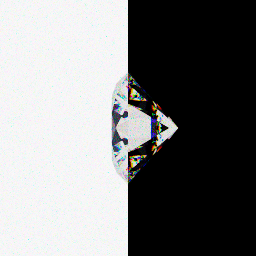

In [12]:
@ti.kernel
def render(theta:ti.f32):
    look_from = tm.vec3(tm.cos(theta),tm.sin(theta),0)*10
    for i,j in film:
        xyz = tm.vec3(0.0)
        for w in range(10):
            wavelength = 380.0+(w+ti.random())*40
            for _ in range(spp):
                u = (i+ti.random())/256
                v = (j+ti.random())/256
                ray = get_ray(u,v,wavelength,look_from)
                xyz += trace(ray) * 1e-13*BlackBody(6500,wavelength)
        xyz = xyz/spp/10
        RGB = xyzToLinearRgb(xyz)*10
        sRGB = ACESToneMapping(RGB)
        film[i,j] = sRGB
render(0)
ti.tools.imshow(film)

#### Optimize rendering efficiency


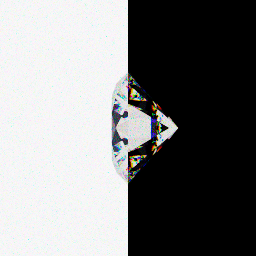

In [13]:
dummy = ti.field(dtype=ti.f32,shape=(256,256,spp,40))
film1 = ti.Vector.field(n=3,dtype=ti.f32,shape=(256, 256))

@ti.kernel
def render(theta:ti.f32):
    look_from = tm.vec3(tm.cos(theta),tm.sin(theta),0)*10
    for i,j,_ ,w in dummy:
        wavelength = 380.0+(w+ti.random())*40
        u = (i+ti.random())/256
        v = (j+ti.random())/256
        ray = get_ray(u,v,wavelength,look_from)
        film1[i,j] += trace(ray) * 1e-13*BlackBody(6500,wavelength)
    
    for i,j in film:
        xyz = film[i,j]/spp/10
        RGB = xyzToLinearRgb(xyz)*10
        sRGB = ACESToneMapping(RGB)
        film1[i,j] = sRGB
render(0)
ti.tools.imshow(film)

### Demonstration and Cut Estimate



- WLR: Weighted Light Return
- DCLR: Dispered Colored Light Return

### More...
- More realistic
  - polarization
  - fluorescence
  - ...
- More artistic
  - glare
- More real time
  - 1 spp denoise
- More gems